# Plain 20 - CIFAR10

Plain20 is defined in Deep Residual Learning for Image Recognition and it is essentially ResNet20-CIFAR without the residual connections. You will need to train this network first and you can do that using [plain20_cifar_baseline_training.yaml](https://github.com/IntelLabs/distiller/blob/new_amc/examples/auto_compression/plain20_cifar_baseline_training.yaml). The trained Plain20 achieves Top1 accuracy of 90.5% on CIFAR-10. The notebook uses data captured in Distiller AMC trace files.

We search for a 50%-MACs-constrained (FLOPs-constrained) Plain20.  From our Greedy Search algorithm we know that there exists a 50%-MACs-constrained Plain20 that can provide Top1=90%.
## Comparing multiple executions

* How stable is the ranking of discovered networks?
 

Let's run 4 instances of AMC (Plain20, DDPG) and then review the results.

In [39]:
%matplotlib inline

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib 
import csv
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
import matplotlib.pylab as pylab
import matplotlib.animation as animation
from matplotlib import animation, rc

from auto_compression_jupyter import *

#plt.style.use('seaborn') # pretty matplotlib plots

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

    
# Widen the cells to get entire rows in the screen.
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

EXPERIMENTS_DIR = os.path.join("/experiments", "amc")

## Multiple experiment runs

We run AMC for 800 episodes. We heat up for the first 100 episodes. During this phase we don't train: the Actor emits actions, to which we add a strong constant noise and fill the replay buffer (the AMC paper refers to this phase as the exploration phase). After completing the heatup phase (100 episodes) we start the learning phase (in AMC parlance this is the exploitation phase) in which we use an exponentially-decaying noise.  After an episode ends, each transition in the trajectory is added to the replay-buffer using an uncommon scheme:

> Following Block-QNN [54], which applies a variant form of Bellman's Equation [50], each transition in an episode is (st; at;R; st+1), where R is the reward after the network is compressed

How should the learning process look like (e.g. the reward curve)? Unfortunately, the AMC paper provides very little information about this. The RL learning is stochastic and two executions of the same experiment can look quite different: one succeeding and another failing - so we need to run our experiments several time.

Below we plot the execution of the same experiment several times.<br>
We configure AMC as follows:
- Architecture: Resnet20 (CIFAR10)
- Action range: 5% - 100% retain rate
- Target density: 50%
- Don't fine-tune a discovered network before providing a reward.

The command-line is provided below:
    
    time python3 ../../classifier_compression/multi-run.py ${AMC_EXP_PATH}/plain20-ddpg-private amc.py  --arch=plain20_cifar ${CIFAR10_PATH} --resume=${CHECKPOINTS_PATH}/checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=DDPG --amc-cfg=auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=hanlab -j=1
    
Each colored line represents one experiment execution instance. We plot the search-Top1 score of discovered networks as the RL-based AMC system learns to find better compressed networks. You might be impressed by:
* The variability in behavior, which is typical for RL algorithms.
 


In [42]:
fpath = os.path.join(EXPERIMENTS_DIR, "plain20-ddpg-private","2019.07.24-174636")
df_list = load_experiment_instances(fpath)

plot_experiment_comparison(df_list)
for i, df in enumerate(df_list):
    print("%d: %s" % (i, [score for score in df.sort_values(by=['top1'], ascending=False).top1[:5]]))

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), IntSlider(value=0, descr…

0: [62.28, 62.040000000000006, 62.0, 61.8, 61.56]
1: [65.12, 65.0, 64.68, 64.52, 64.4]
2: [65.0, 64.68, 63.88, 63.75999999999999, 63.75999999999999]
3: [63.8, 63.68000000000001, 63.6, 63.56, 63.56]


Fine-tune for 2 epochs (using 16 processes): notice the low LR which we use because we only FT for 2 episodes.

    time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-ddpg-private/2019.07.24-174636 --arch=plain20_cifar --lr=0.001 --vs=0 -p=50 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --epochs=2 --output-csv=ft_2epoch_results.csv --processes=16


Fine-tune for 60 epochs (using 16 processes): notice the x100 higher LR.

    time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-ddpg-private/2019.07.24-174636 --arch=plain20_cifar --lr=0.1 --vs=0 -p=50 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --epochs=60 --output-csv=ft_60epoch_results.csv --processes=16

* Bubbles represent discovered networks
* Bubble sizes represent the relative number of FLOPs in each network
* Darker networks were discovered later in the search process 

Best network: 83.14
Pearson: 0.902
   exp  search_top1   top1                                     name
59   2        60.92  83.14  BEST_adc_episode_221_checkpoint.pth.tar
58   2        60.84  82.92  BEST_adc_episode_211_checkpoint.pth.tar
71   2        64.68  82.82  BEST_adc_episode_588_checkpoint.pth.tar
11   1        58.20  82.72  BEST_adc_episode_266_checkpoint.pth.tar
68   2        63.56  82.72  BEST_adc_episode_424_checkpoint.pth.tar
Best network: 90.04
Pearson: 0.699
   exp  search_top1   top1                                     name
72   2        65.00  90.04  BEST_adc_episode_777_checkpoint.pth.tar
65   2        62.36  90.02  BEST_adc_episode_378_checkpoint.pth.tar
56   2        60.36  89.96  BEST_adc_episode_199_checkpoint.pth.tar
53   2        58.24  89.94  BEST_adc_episode_126_checkpoint.pth.tar
41   3        63.84  89.93  BEST_adc_episode_357_checkpoint.pth.tar
92


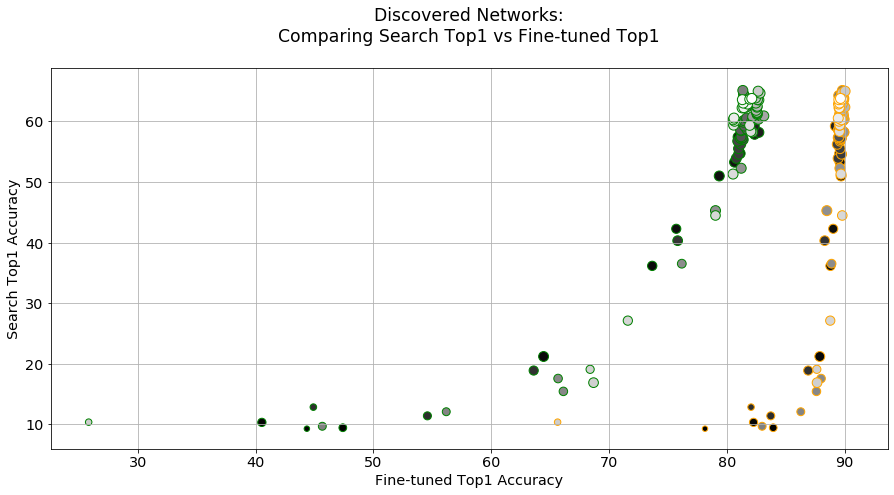

In [43]:
df_plain20_ft60 = pd.read_csv(os.path.join(fpath, "ft_60epoch_results.csv"))
df_plain20_ft2 = pd.read_csv(os.path.join(fpath, "ft_2epoch_results.csv"))

shorten_dir_name(df_plain20_ft2)
shorten_dir_name(df_plain20_ft60)
create_fig("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\n",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")
plot_networks(df_plain20_ft2, edgecolors='green')
plot_networks(df_plain20_ft60, edgecolors='orange')
print(len(df_plain20_ft60.index))


Let's zoom-in on the FT60 networks.<br>
Remember, we ran our AMC experiment 4 times, and we fine-tuned networks discovered in each of these 4 experiments. Now let's separate these networks by color and observe how they cluster.

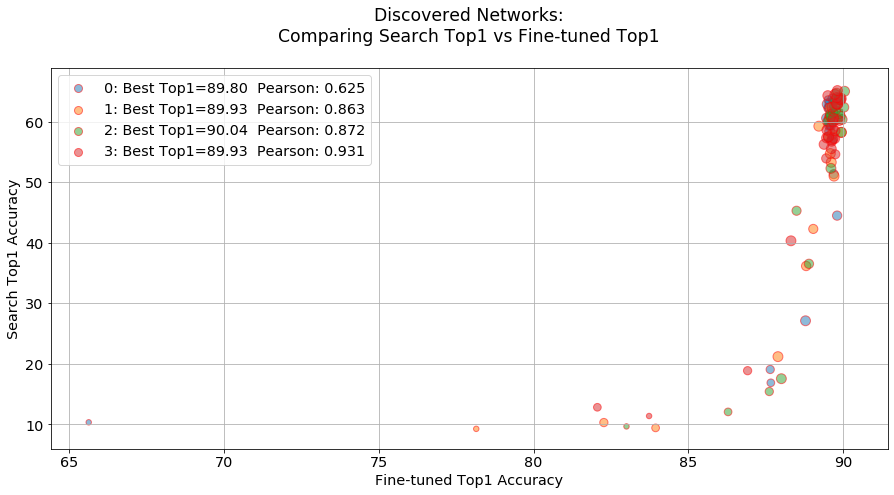

In [44]:
create_fig("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\n",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")
plot_networks_by_experiment(df_plain20_ft60, edgecolors='red')

(0.32623976968406065, 0.026918228305542857)


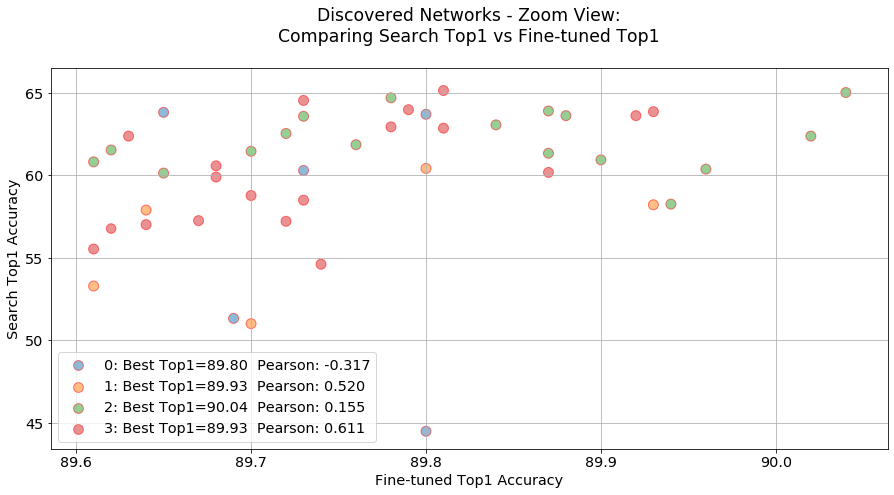

In [45]:
df_sorted = df_plain20_ft60.sort_values(by=['top1'], ascending=False)
df_sorted = df_sorted[:int(len(df_sorted.index) * 0.5)]  # Top 30% models
create_fig("Discovered Networks - Zoom View:\nComparing Search Top1 vs Fine-tuned Top1\n",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")
plot_networks_by_experiment(df_sorted, edgecolors='red')

from scipy.stats.stats import pearsonr
print(pearsonr(df_sorted.top1, df_sorted.search_top1))

## Clipped PPO
What happens if we use a different agent, such as Clipped PPO?
Results are interesting and encouraging as there is learning. However, this is less sample-efficient compared to DDPG, and therefore takes longer.
There might be some room to tune the PPO hyper-params to generate better results.

    time python3 ../../classifier_compression/multi-run.py ${AMC_EXP_PATH}/plain20-ppo-coach amc.py --arch=plain20_cifar ${CIFAR10_PATH} --resume=${CHECKPOINTS_PATH}/checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=ClippedPPO-continuous --amc-cfg=auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=coach -j=1

In [46]:
fpath = os.path.join(EXPERIMENTS_DIR, "plain20-ppo-coach", "2019.07.28-012356")
df_list = load_experiment_instances(fpath)
df_len = min([len(df) for df in df_list])

plot_experiment_comparison(df_list)

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), IntSlider(value=0, descr…

    time python3 parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-ppo-coach/2019.07.28-012356 --arch=plain20_cifar --lr=0.1 --vs=0 -p=50 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --epochs=60 --output-csv=ft_60epoch_results.csv --processes=16

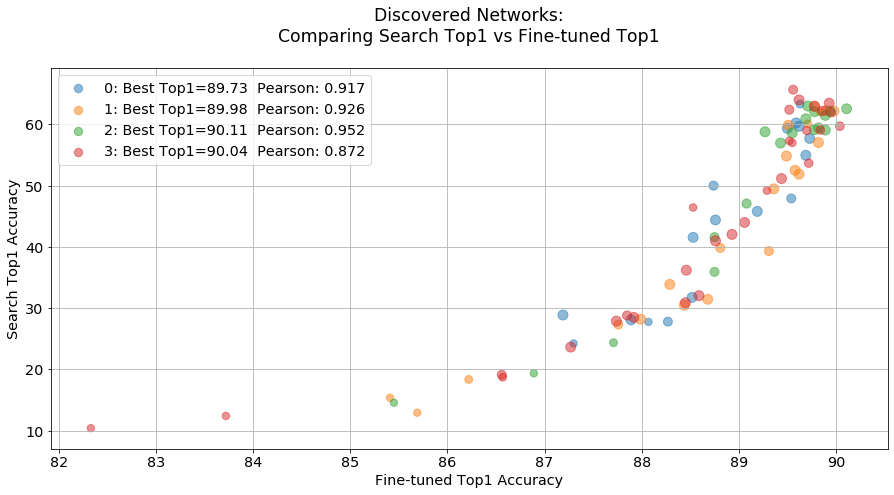

In [47]:
df_plain20_ft60 = pd.read_csv(os.path.join(fpath, "ft_60epoch_results.csv"))
shorten_dir_name(df_plain20_ft60)

create_fig("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\n",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")
plot_networks_by_experiment(df_plain20_ft60, edgecolors=None)

## Using a different reward function

    time python3 ../../classifier_compression/multi-run.py ${AMC_EXP_PATH}/plain20-ddpg-private-punish amc.py --arch=plain20_cifar ${CIFAR10_PATH} --resume=${CHECKPOINTS_PATH}/checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc-protocol=punish-agent --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=DDPG --amc-cfg=auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=hanlab -j=1

In [48]:
fpath = os.path.join(EXPERIMENTS_DIR, "plain20-ddpg-private-punish", "2019.07.29-171102")
df_list = load_experiment_instances(fpath)
df_len = min([len(df) for df in df_list])

plot_experiment_comparison(df_list)

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), IntSlider(value=0, descr…

    time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-ddpg-private-punish/2019.07.29-171102 --arch=plain20_cifar --lr=0.1 --vs=0 -p=50 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --epochs=60 --output-csv=ft_60epoch_results.csv --processes=16

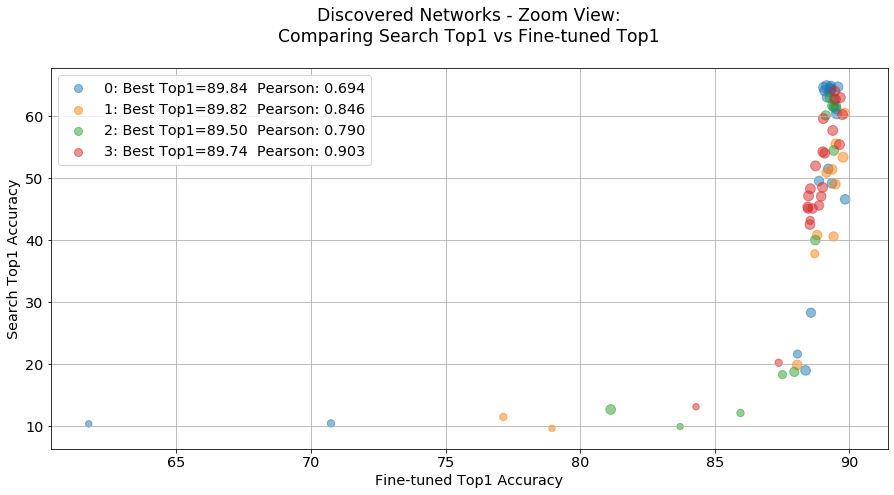

In [49]:
df_plain20_ft60 = pd.read_csv(os.path.join(fpath, "ft_60epoch_results.csv"))
shorten_dir_name(df_plain20_ft60)
#df_plain20_ft60 = df_plain20_ft60[df_plain20_ft60[df_plain20_ft60.macs] >= 50.5] 

create_fig("Discovered Networks - Zoom View:\nComparing Search Top1 vs Fine-tuned Top1\n",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")
plot_networks_by_experiment(df_plain20_ft60, edgecolors=None)

## Increase the number of images we use for scoring

Let's go back to DDPG, and try to assess what happens when we increase the validation dataset.
We use the validation dataset both for reconstruction of feature-maps and for computing the reward.  Our original configuration is:

    Dataset sizes:
        training=22500
        validation=2500
        test=750

Since we don't fine-tune in this setup, the size of the training DS is irrelevant.  The same is true for the test DS, since it's not used.

    Dataset sizes:
        training=450
        validation=5000
        test=750

    time python3 ../../classifier_compression/multi-run.py ${AMC_EXP_PATH}/plain20-ddpg-private amc.py  --arch=plain20_cifar ${CIFAR10_PATH} --resume=${CHECKPOINTS_PATH}/checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=DDPG --amc-cfg=auto_compression_channels.yaml --evs=1.0 --etrs=0.01 --amc-rllib=hanlab -j=1
    
    time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-ddpg-private/2019.08.01-181040 --arch=plain20_cifar --lr=0.1 --vs=0 -p=50 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --epochs=60 --output-csv=ft_60epoch_results.csv --processes=16

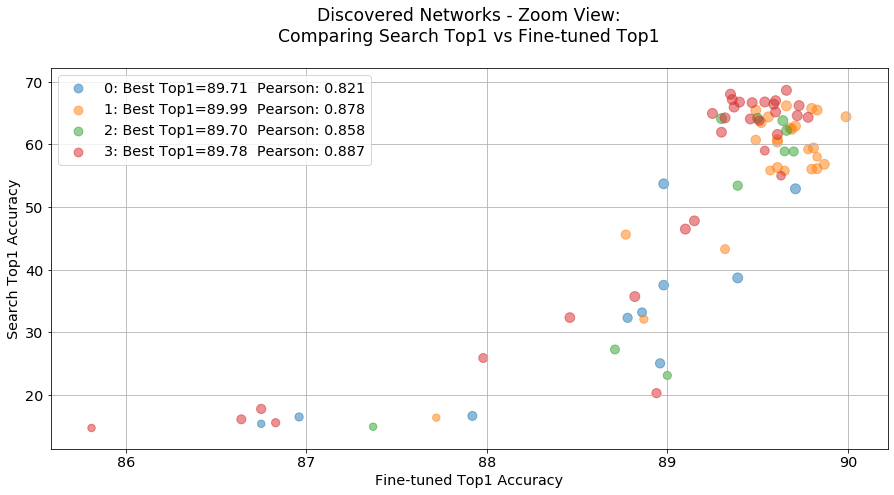

In [50]:
fpath = os.path.join(EXPERIMENTS_DIR,
                     "plain20-ddpg-private",
                     "2019.08.01-181040")
df_plain20_ft60 = pd.read_csv(os.path.join(fpath, "ft_60epoch_results.csv"))
shorten_dir_name(df_plain20_ft60)
#df_plain20_ft60 = df_plain20_ft60[df_plain20_ft60[df_plain20_ft60.macs] >= 50.5] 

create_fig("Discovered Networks - Zoom View:\nComparing Search Top1 vs Fine-tuned Top1\n",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")
plot_networks_by_experiment(df_plain20_ft60, edgecolors=None)

Now repeating the original experiment, with checkpoint savings so we can fine-tune the best ones

    time python3 ../../classifier_compression/multi-run.py ${AMC_EXP_PATH}/plain20-ddpg-private amc.py  --arch=plain20_cifar ${CIFAR10_PATH} --resume=${CHECKPOINTS_PATH}/checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=DDPG --amc-cfg=auto_compression_channels.yaml --evs=0.5 --etrs=0.01 --amc-rllib=hanlab -j=1 --amc-save-chkpts
    
    time python3 ../../classifier_compression/parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-ddpg-private/2019.08.03-000628 --arch=plain20_cifar --lr=0.1 --vs=0 -p=50 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --epochs=60 --output-csv=ft_60epoch_results.csv --processes=16 --top-performing-chkpts

In [51]:
fpath = os.path.join(EXPERIMENTS_DIR,
                     "plain20-ddpg-private",
                     "2019.08.03-000628")

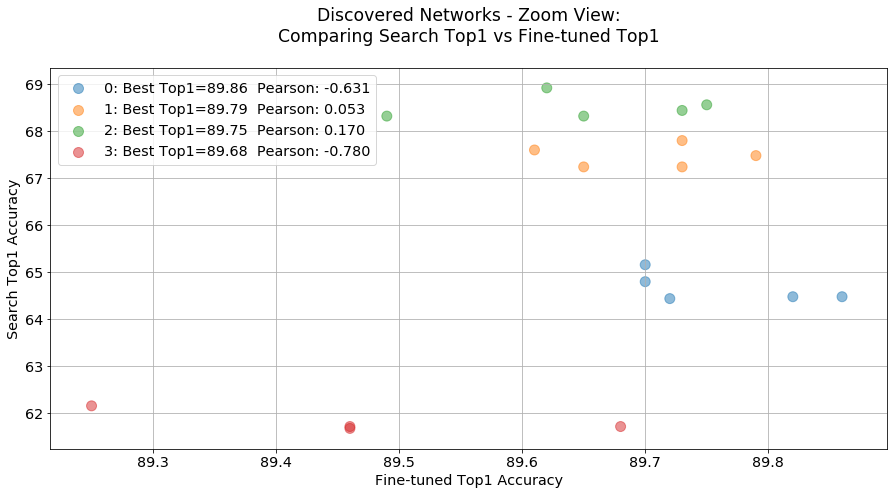

In [53]:
df_plain20_ft60 = pd.read_csv(os.path.join(fpath, "ft_60epoch_results.csv"))
shorten_dir_name(df_plain20_ft60)

create_fig("Discovered Networks - Zoom View:\nComparing Search Top1 vs Fine-tuned Top1\n",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")
plot_networks_by_experiment(df_plain20_ft60, edgecolors=None)

In [54]:
_mean = df_plain20_ft60.top1.mean()
_std = df_plain20_ft60.top1.std()
_max = mean = df_plain20_ft60.top1.max()
_max, _mean, _std

(89.86, 89.65263157894738, 0.14771752718027756)

In [55]:
df_list = load_experiment_instances(fpath)
plot_experiment_comparison(df_list)

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), IntSlider(value=0, descr…